In [29]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import warnings

import params as p
import functions as f

from xgboost import XGBRegressor

from sklearn.ensemble import RandomForestRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import mean_squared_error
from sklearn.inspection import PartialDependenceDisplay

import optuna
from optuna.integration import XGBoostPruningCallback

### Settings

In [3]:
warnings.simplefilter(action='ignore', category=FutureWarning)

### Import Data

In [4]:
train, test, val = f.load_split_datasets(part='03')

In [5]:
X_train, y_train = f.split_data_X_y(train)
X_test, y_test = f.split_data_X_y(test)
X_val, y_val = f.split_data_X_y(val)

In [6]:
train_data = {'X' : X_train, 'y' : y_train}
test_data = {'X' : X_test, 'y' : y_test}
val_data = {'X' : X_val, 'y' : y_val}

### Create Models

#### XGB

In [7]:
xgb = XGBRegressor(random_state = p.RANDOM_STATE).fit(**train_data)

#### RandomForest

In [8]:
rf = RandomForestRegressor(random_state=p.RANDOM_STATE).fit(**train_data)

#### Naive Bayes

In [9]:
nb = GaussianNB().fit(**train_data)

### Evaluate Initial Models on Validation Data

In [10]:
rmse = {'RMSE' : [f.evaluate_model(model, metric = 'rmse', **val_data) for model in [xgb, rf, nb]]}
pd.DataFrame(rmse, index = ['XGBoost', 'RandomForest', 'Naive Bayes'])

,RMSE
XGBoost,210.904391
RandomForest,222.486178
Naive Bayes,531.287298


### Tuning with Optuna

### XGB

In [11]:
xgb_base_params = {
    'learning_rate' : 0.1,
    'verbosity' : 0,
    'n_jobs' : -1,
    'random_state' : p.RANDOM_STATE,
    }

def xgb_objective(trial, X_train = X_train, y_train = y_train, X_test = X_test, y_test = y_test, base_params = xgb_base_params):

    obj_params = {
        'max_depth' : trial.suggest_int('max_depth', 2, 7),
        'min_child_weight' : trial.suggest_int('min_child_weight', 1, 10),
        'n_estimators' : trial.suggest_int('n_estimators', 50, 1000),
        'subsample' : trial.suggest_float('subsample', 0.1, 1),

        **base_params
        }

    pruning_callback = XGBoostPruningCallback(trial, observation_key = 'validation_1-rmse')

    xgb_obj = XGBRegressor(**obj_params)
    xgb_obj.fit(
        X_train,
        y_train,
        eval_metric = 'rmse',
        eval_set = [(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds = obj_params['n_estimators'] * 0.1,
        verbose = 0,
        callbacks = [pruning_callback]
        )

    y_pred = xgb_obj.predict(X_test)

    rmse = (mean_squared_error(y_true = y_test, y_pred = y_pred)) ** 0.5
    
    return rmse

xgb_study = optuna.create_study(direction = 'minimize')
xgb_study.optimize(xgb_objective, n_trials = 200, n_jobs = -1)

[I 2022-03-25 16:02:42,330] A new study created in memory with name: no-name-2348d2e8-273e-4120-baca-7d002468a1cf
[I 2022-03-25 16:02:48,668] Trial 6 finished with value: 204.53043715854693 and parameters: {'max_depth': 5, 'min_child_weight': 8, 'n_estimators': 121, 'subsample': 0.924708474225307}. Best is trial 6 with value: 204.53043715854693.
[I 2022-03-25 16:02:51,716] Trial 0 finished with value: 208.01959125355236 and parameters: {'max_depth': 4, 'min_child_weight': 1, 'n_estimators': 225, 'subsample': 0.8891092705139054}. Best is trial 6 with value: 204.53043715854693.
[I 2022-03-25 16:02:55,391] Trial 4 finished with value: 201.30325778555044 and parameters: {'max_depth': 5, 'min_child_weight': 9, 'n_estimators': 470, 'subsample': 0.47109795728084114}. Best is trial 4 with value: 201.30325778555044.
[I 2022-03-25 16:02:55,469] Trial 8 finished with value: 231.69170417306947 and parameters: {'max_depth': 5, 'min_child_weight': 9, 'n_estimators': 191, 'subsample': 0.1066342565284

In [12]:
xgb_tuned_params = {**xgb_study.best_params, **xgb_base_params}
xgb_tuned_params

{'max_depth': 7,
 'min_child_weight': 1,
 'n_estimators': 771,
 'subsample': 0.5839247145301004,
 'learning_rate': 0.1,
 'verbosity': 0,
 'n_jobs': -1,
 'random_state': 73}

### RandomForest

In [13]:
rf_base_params = {
    'verbose' : 0,
    'random_state' : p.RANDOM_STATE,
    }

def rf_objective(trial, X_train = X_train, y_train = y_train, X_test = X_test, y_test = y_test, base_params = rf_base_params):

    obj_params = {
        'max_depth' : trial.suggest_int('max_depth', 2, 20),
        'max_features' : trial.suggest_categorical('max_features', ['auto', 'sqrt']),
        'n_estimators' : trial.suggest_int('n_estimators', 50, 1000),
        'bootstrap' : trial.suggest_categorical('bootstrap', [True, False]),
        'min_samples_leaf' : trial.suggest_float('min_samples_leaf', 0, 0.5),
        'min_samples_split' : trial.suggest_float('min_samples_split', 0, 0.5),

        **base_params
    }

    rf_obj = RandomForestRegressor(**obj_params)
    rf_obj.fit(X_train, y_train)

    y_pred = rf_obj.predict(X_test)

    rmse = (mean_squared_error(y_true = y_test, y_pred = y_pred)) ** 0.5
    
    return rmse

rf_study = optuna.create_study(direction='minimize')
rf_study.optimize(rf_objective, n_trials = 200, n_jobs = -1)

[I 2022-03-25 16:06:17,237] A new study created in memory with name: no-name-1743dae1-184a-4f85-8da3-adfa3e869b88
[I 2022-03-25 16:06:18,122] Trial 2 finished with value: 591.9544157185678 and parameters: {'max_depth': 12, 'max_features': 'sqrt', 'n_estimators': 50, 'bootstrap': True, 'min_samples_leaf': 0.28840347850818393, 'min_samples_split': 0.13543711913392947}. Best is trial 2 with value: 591.9544157185678.
[I 2022-03-25 16:06:18,270] Trial 0 finished with value: 639.3581206096308 and parameters: {'max_depth': 3, 'max_features': 'auto', 'n_estimators': 75, 'bootstrap': True, 'min_samples_leaf': 0.4644763222872101, 'min_samples_split': 0.07591047384532562}. Best is trial 2 with value: 591.9544157185678.
[I 2022-03-25 16:06:18,522] Trial 5 finished with value: 595.8470565581723 and parameters: {'max_depth': 12, 'max_features': 'sqrt', 'n_estimators': 91, 'bootstrap': False, 'min_samples_leaf': 0.47349318599755646, 'min_samples_split': 0.21794187053993802}. Best is trial 2 with valu

In [14]:
rf_tuned_params = {**rf_study.best_params, **rf_base_params}
rf_tuned_params

{'max_depth': 9,
 'max_features': 'auto',
 'n_estimators': 667,
 'bootstrap': False,
 'min_samples_leaf': 0.0012913769356413937,
 'min_samples_split': 0.01029219299259564,
 'verbose': 0,
 'random_state': 73}

### Naive Bayes

In [15]:
def nb_objective(trial, X_train = X_train, y_train = y_train, X_test = X_test, y_test = y_test):

    obj_params = {
        'var_smoothing' : trial.suggest_loguniform('var_smoothing', 1e-9, 1),
    }

    nb_obj = GaussianNB(**obj_params)
    nb_obj.fit(X_train, y_train)

    y_pred = nb_obj.predict(X_test)

    rmse = (mean_squared_error(y_true = y_test, y_pred = y_pred)) ** 0.5
    
    return rmse

nb_study = optuna.create_study(direction='minimize')
nb_study.optimize(nb_objective, n_trials = 200, n_jobs = -1)

[I 2022-03-25 16:10:32,717] A new study created in memory with name: no-name-e81cb29e-ceed-4850-86bb-9a71c70a698f
[I 2022-03-25 16:10:35,180] Trial 3 finished with value: 849.7792452634234 and parameters: {'var_smoothing': 0.0007409877092078856}. Best is trial 3 with value: 849.7792452634234.
[I 2022-03-25 16:10:35,188] Trial 4 finished with value: 559.866196504277 and parameters: {'var_smoothing': 2.890662228331417e-05}. Best is trial 4 with value: 559.866196504277.
[I 2022-03-25 16:10:35,190] Trial 0 finished with value: 716.6248793835442 and parameters: {'var_smoothing': 0.00012335659633803806}. Best is trial 4 with value: 559.866196504277.
[I 2022-03-25 16:10:35,190] Trial 1 finished with value: 508.9964043536756 and parameters: {'var_smoothing': 7.25005613297913e-09}. Best is trial 1 with value: 508.9964043536756.
[I 2022-03-25 16:10:35,190] Trial 5 finished with value: 852.9386625837626 and parameters: {'var_smoothing': 0.0004668843347036212}. Best is trial 1 with value: 508.9964

In [16]:
nb_tuned_params = nb_study.best_params.copy()
nb_tuned_params

{'var_smoothing': 7.197920512268857e-07}

### Evaluate Final, Tuned Models on validation data

### XGB

In [17]:
xgb_tuned = XGBRegressor(**xgb_tuned_params)
xgb_tuned.fit(
    **train_data,
    eval_metric = 'rmse',
    eval_set = [(X_train, y_train), (X_test, y_test)],
    early_stopping_rounds = xgb_tuned_params['n_estimators'] * 0.1,
    verbose = 0
    )

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.1, max_delta_step=0,
             max_depth=7, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=771, n_jobs=-1,
             num_parallel_tree=1, predictor='auto', random_state=73,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             subsample=0.5839247145301004, tree_method='exact',
             validate_parameters=1, verbosity=0)

### RandomForest

In [18]:
rf_tuned = RandomForestRegressor(**rf_tuned_params).fit(**train_data)

### Naive Bayes

In [19]:
nb_tuned = GaussianNB(**nb_tuned_params).fit(**train_data)

### Evaluate results on validation data

In [60]:
tuned_rmse = {'RMSE' : [f.evaluate_model(model, metric = 'rmse', **val_data) for model in [xgb_tuned, rf_tuned, nb_tuned]]}
pd_rmse = pd.DataFrame(tuned_rmse, index = ['XGBoost', 'RandomForest', 'Naive Bayes'])
pd_rmse

,RMSE
XGBoost,197.595627
RandomForest,281.279289
Naive Bayes,439.334751


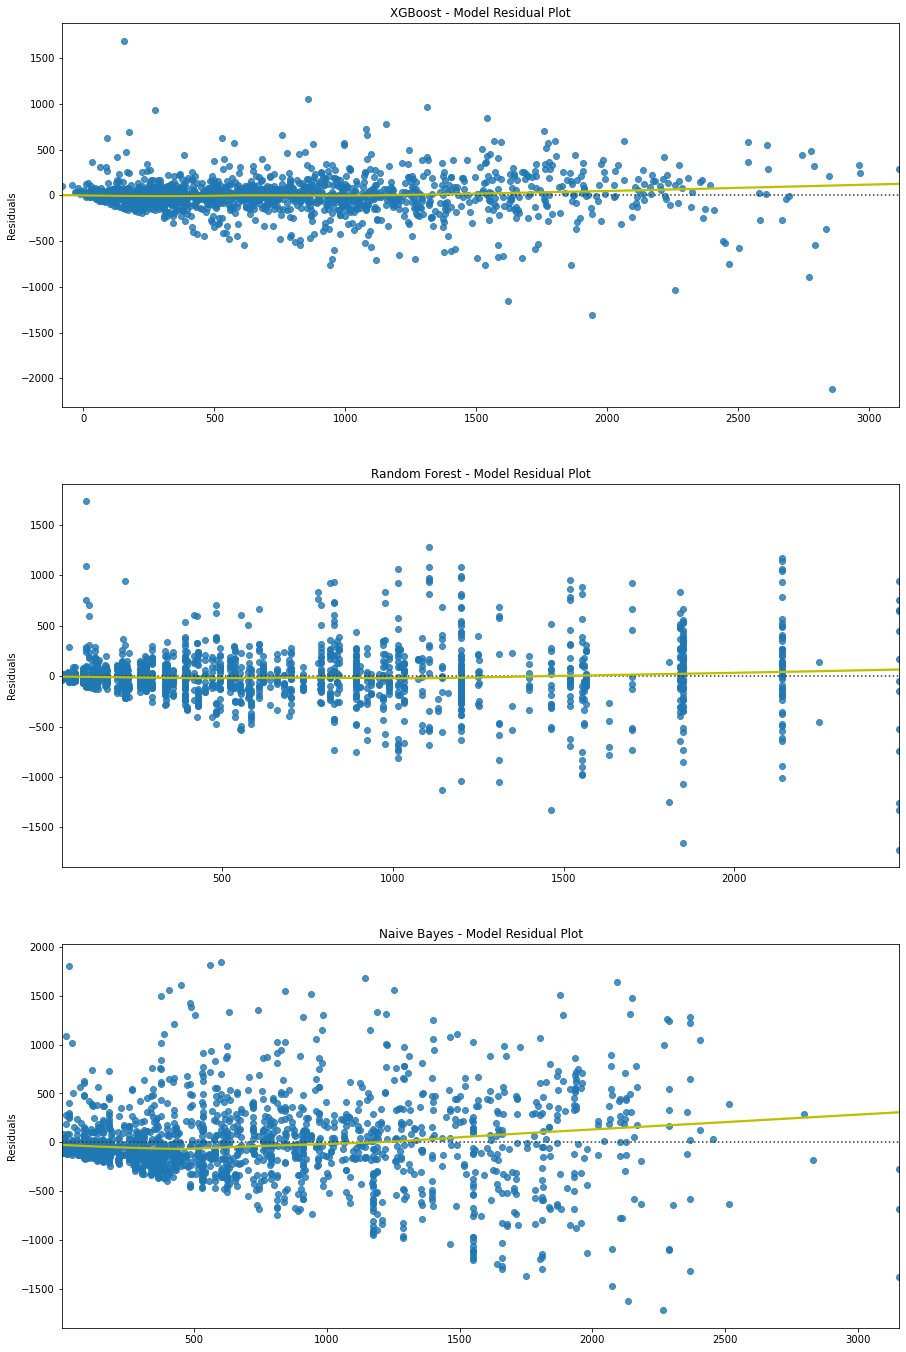

In [58]:
def make_residual_plot():

    fig, ax = plt.subplots(nrows = 3, ncols = 1, figsize=(15, 24))

    for idx, model_info in enumerate([('XGBoost', xgb_tuned), ('Random Forest', rf_tuned), ('Naive Bayes', nb_tuned)]):

        model_name = model_info[0]
        model = model_info[1]

        sns.residplot(
            ax = ax[idx],
            x = model.predict(X_val),
            y = y_val,
            lowess = True,
            line_kws = {'color' : 'y'}
        ).set(title = f'{model_name} - Model Residual Plot', ylabel = 'Residuals')

    plt.show()

make_residual_plot()